In [46]:
import pandas as pd 
from dowhy import CausalModel
import matplotlib.pyplot as plt

In [47]:
matches_df = pd.read_csv('./out/matches_df.csv')

We want to transform matches_df into a dataframe where each row represents one game for one team so that we can analyse the effect of goldlead at 15 has on team as an indiviual not as Team_A and team_B further interesting to plot the increase in win prob given that there is a gold lead 

Right now the large lead is defined as a one thousand goldlead at minute 15 but with one line of code one can replace that as seen later 

In [48]:
print(matches_df.dtypes)

Unnamed: 0.1             int64
Unnamed: 0               int64
gameid                  object
date                    object
league                  object
playoffs                 int64
patch                  float64
gamelength               int64
days_since_patch         int64
team_a                  object
team_b                  object
winner                  object
recent_patch             int64
elo_a                  float64
elo_b                  float64
winstreak_a            float64
winstreak_b            float64
elo_diff               float64
underdog                object
underdog_side_adv        int64
upset                    int64
vision_score_team_A    float64
vision_score_team_B    float64
team_kills_team_A      float64
team_kills_team_B      float64
abs_golddiff_15        float64
golddiffat15           float64
total_kills            float64
vision_diff            float64
large_lead_A             int64
large_lead_B             int64
resultA                  int64
resultB 

In [49]:
#We need to define columns that would be identical for each team 
common_cols = ['gameid', 'date', 'league', 'patch', 'playoffs', 'gamelength', 
               'days_since_patch', 'golddiffat15', 'recent_patch']

#Now for team-specific columns 
team_cols = {
    'blue': {
        'teamid': 'team_a',
        'result': 'resultA',
        'win_prob': 'win_prob_A',
        'large_lead': 'large_lead_A',
        'underdog': 'underdog_A',
        'elo': 'elo_a',
        'kills' : 'team_kills_team_A',
        'winstreak': 'winstreak_a',
        'visionscore': 'vision_score_team_A'
    },
    'red': {
        'teamid': 'team_b',
        'result': 'resultB',
        'win_prob': 'win_prob_B',
        'large_lead': 'large_lead_B',
        'underdog': 'underdog_B',
        'elo': 'elo_b',
        'kills' : 'team_kills_team_B',
        'winstreak': 'winstreak_b',
        'visionscore': 'vision_score_team_B'
    }
}

long_dfs = []
for side, mapping in team_cols.items():
    df = matches_df[common_cols + list(mapping.values())].copy()
    df = df.rename(columns={
        mapping['teamid']: 'teamid',
        mapping['result']: 'result',
        mapping['win_prob']: 'win_prob',
        mapping['large_lead']: 'large_lead',
        mapping['underdog']: 'underdog',
        mapping['elo']: 'elo',
        mapping['winstreak']: 'winstreak',
        mapping['kills']: 'kills',
        mapping['visionscore']: 'visionscore'
    })
    df['side'] = side  # 'A' or 'B'
    long_dfs.append(df)

long_df = pd.concat(long_dfs, ignore_index=True)

long_df['golddiffat15'] = long_df.apply(
    lambda row: row['golddiffat15'] if row['side'] == 'blue' else -row['golddiffat15'],
    axis=1
)
long_df['side_adv'] = long_df.apply(
    lambda row: 1 if row['side'] == 'blue' else 0, 
    axis=1
)
# Then redefine large_lead based on the updated golddiffat15
long_df['large_lead'] = (long_df['golddiffat15'] > 1000).astype(int)

In [50]:
print(long_df.dtypes)

gameid               object
date                 object
league               object
patch               float64
playoffs              int64
gamelength            int64
days_since_patch      int64
golddiffat15        float64
recent_patch          int64
teamid               object
result                int64
win_prob            float64
large_lead            int64
underdog               bool
elo                 float64
kills               float64
winstreak           float64
visionscore         float64
side                 object
side_adv              int64
dtype: object


In [51]:
def calculate_gold_lead_effect(causal_graph, gold_lead_threshold):
    #First we redefine the gold lead in the dataset
    long_df['large_lead'] = (long_df['golddiffat15'] > gold_lead_threshold).astype(int)

    #Then we run the estimation for said gold_lead_threshold with the given causal_graph
    #1. Build the model using the causal graph given
    model = CausalModel(
        data=long_df,
        treatment='large_lead',
        outcome='result',
        graph=causal_graph
    )

    #2. Use identification to identifiy the estimand
    identified_estimand = model.identify_effect()

    #3. Estimation (For now just using linear regression)
    estimate = model.estimate_effect(
        identified_estimand,
        method_name='backdoor.linear_regression'
    )

    #4. Return the value of the estimation 
    return estimate.value


In [52]:
#Lets say we want to run over multiple gold leads to later model them 
gold_leads = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]
effect_gold_lead = []

causal_graph = '''
digraph {
    large_lead -> result;
    win_prob -> large_lead;
    win_prob -> result;
    side_adv -> large_lead;
    side_adv -> result
}
'''

for threshold in gold_leads:
    retval = calculate_gold_lead_effect(causal_graph, threshold)
    effect_gold_lead.append(retval)

for i in range(len(effect_gold_lead)):
    print(f'Estimated effect of a {gold_leads[i]} large gold lead: {effect_gold_lead[i]}')

Estimated effect of a 500 large gold lead: 0.2444295585212266
Estimated effect of a 1000 large gold lead: 0.2643644809725657
Estimated effect of a 1500 large gold lead: 0.2898683955357769
Estimated effect of a 2000 large gold lead: 0.31225018322504017
Estimated effect of a 2500 large gold lead: 0.3505621574188964
Estimated effect of a 3000 large gold lead: 0.40142555335380903
Estimated effect of a 3500 large gold lead: 0.41345632092233753
Estimated effect of a 4000 large gold lead: 0.3990902743228734
Estimated effect of a 4500 large gold lead: 0.3856434455734918


In [53]:
causal_graph = '''
digraph {
    golddiffat15 -> result;
    win_prob -> golddiffat15;
    win_prob -> result;
    side_adv -> golddiffat15;
    side_adv -> result
}
'''

# Build causal model directly on matches_df
model = CausalModel(
    data=long_df,
    treatment='golddiffat15',
    outcome='result',
    graph=causal_graph
)

# Identify effect
identified_estimand = model.identify_effect()

# Estimate causal effect using linear regression (backdoor)
estimate = model.estimate_effect(
    identified_estimand,
    method_name='backdoor.linear_regression'
)

unit_effect = estimate.value
print("Causal Estimate causal effect of one unit in the golddiffat15 on the result:", estimate.value)
print(f"For example this would be the estimated effect when we have a golddiffat15 of 1000: {estimate.value * 1000}")
#print(estimate)

Causal Estimate causal effect of one unit in the golddiffat15 on the result: 0.0001340584142000001
For example this would be the estimated effect when we have a golddiffat15 of 1000: 0.1340584142000001


Now we want to plot the causal effect as measured by one unit in the golddiffat15 and also as measured by the an amount of large_leads 

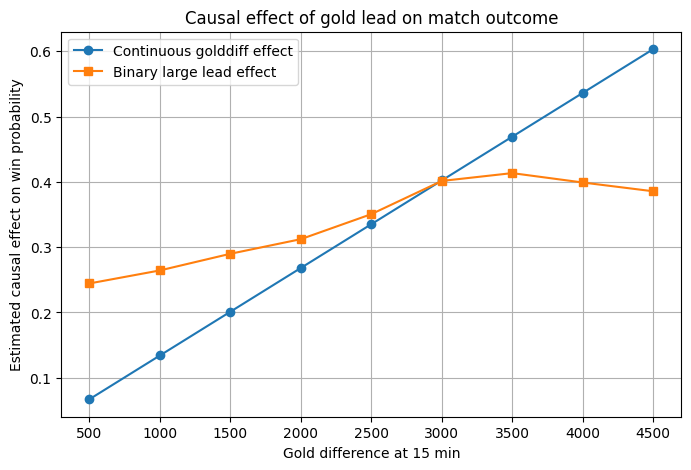

In [54]:
#Get the effects measured by the unit effect from golddiffat15
continuous_effects = [unit_effect * g for g in gold_leads]

plt.figure(figsize=(8,5))
plt.plot(gold_leads, continuous_effects, marker='o', label='Continuous golddiff effect')
plt.plot(gold_leads, effect_gold_lead, marker='s', label='Binary large lead effect')

plt.xlabel('Gold difference at 15 min')
plt.ylabel('Estimated causal effect on win probability')
plt.title('Causal effect of gold lead on match outcome')
plt.legend()
plt.grid(True)
plt.show()